# import single xrf file and do all the processing by training on that file

In [1]:
import beamtime_config_2018
# import ROI_Finder_2018
from beamtime_config_2018 import *
# from ROI_Finder_2018 import *

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from matplotlib import rc
from matplotlib.widgets import LassoSelector
from matplotlib.path import Path
import seaborn as sns

import xrf_roif_2022

from xrf_roif_2022 import *

%matplotlib inline

In [2]:
# current_xrf_filename = '/home/beams/USERBNP/arshad/Practice_h5/bnp_fly0032.mda.h5'

# base_file_path = '/home/beams/USERBNP/arshad/Practice_h5/'

base_file_path = 'beamtime_data/'


current_xrf_filename = base_file_path + 'bnp_fly0032.mda.h5'


x= beamtime_XRF_image(xrf_filename = current_xrf_filename,
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='MAPS')
# x.add_noise(noise=noise_type)

x.binary_conversion(e='P')
x.extract_cells()
X_bin1=x.binary_img  


X_Cu1=x.Patches_Cu
X_Zn1=x.Patches_Zn
X_Ca1=x.Patches_Ca
X_K1=x.Patches_K
X_P1=x.Patches_P
X_S1=x.Patches_S
X_Fe1=x.Patches_Fe
X_Ni1=x.Patches_Ni
X_TFY1=x.Patches_TFY

X_x_res1=x.x_res_list
X_y_res1=x.y_res_list
X_avg_res1=x.avg_res_list
X_x_origin1=x.x_origin_list
X_y_origin1=x.y_origin_list

X_x_motor1=x.x_motor_center_list
X_y_motor1=x.y_motor_center_list


SNR_X1=calc_SNR(x.d_Zn, x.binary_ero_dil)

X1=x.features

X_centers1=x.center_coords
X_xrf_track_file1=x.XRF_track_files

X1.shape

chs: ['Si', 'P', 'S', 'Cl', 'K', 'Ca', 'Ti', 'Cr', 'Fe', 'Cu', 'Zn', 'Ag_L', 'Si_Cl', 'Num_Iter', 'Total_Fluorescence_Yield', 'Si_Si', 'Cl_Cl', 'COHERENT_SCT_AMPLITUDE', 'COMPTON_AMPLITUDE', 'Fit_Residual', 'Sum_Elastic_Inelastic']


(32, 14)

In [3]:
# x.center_coords
# x.center_list
# SNR_X1

In [4]:
# %matplotlib inline

# print(x.d_K.shape)
# plt.figure(dpi=200)
# plt.imshow(x.d_P)
# plt.colorbar(orientation='vertical', shrink=0.7)
# plt.gca().invert_yaxis()

In [5]:
# print(x.d_K.shape)
# plt.figure(dpi=200)
# plt.imshow(x.binary_ero_dil)
# plt.colorbar(orientation='horizontal', shrink=0.5)
# plt.gca().invert_yaxis()

In [6]:
# print(x.d_K.shape)
# plt.figure(dpi=200)
# plt.imshow(x.binary_img[29])
# plt.colorbar(orientation='horizontal', shrink=0.5)
# plt.gca().invert_yaxis()

# combine all extraction into single arrays

In [7]:
X=X1

X_bin=np.asarray(X_bin1)


X_Cu = np.asarray(X_Cu1)
X_Zn = np.asarray(X_Zn1)
X_Ca = np.asarray(X_Ca1)
X_K = np.asarray(X_K1)
X_P = np.asarray(X_P1)
X_S = np.asarray(X_S1)
X_Fe = np.asarray(X_Fe1)
X_Ni = np.asarray(X_Ni1)
X_TFY = np.asarray(X_TFY1)

X_x_res = np.asarray(X_x_res1)
X_y_res = np.asarray(X_y_res1)
X_avg_res = np.asarray(X_avg_res1)
X_x_origin = np.asarray(X_x_origin1)
X_y_origin = np.asarray(X_y_origin1)



X_centers = np.asarray(X_centers1)
X_x_motor = np.asarray(X_x_motor1)
X_y_motor = np.asarray(X_y_motor1)
X_xrf_track_files=np.asarray(X_xrf_track_file1)


print('Total extracted cells, features:', X.shape)
print('Total extracted cell, cell size:', X_bin.shape)


Total extracted cells, features: (32, 14)
Total extracted cell, cell size: (32, 32, 32)


# construct dataframe with all the extracted information

In [8]:
BASE_PATCH_WIDTH=x.BASE_PATCH_WIDTH
principalDf = pd.DataFrame(
             columns = ['Pixel_count', 'area'])

principalDf['area'] = X[:,0]
principalDf['eccentricity'] = X[:,1]
principalDf['equivalent_diameter'] = X[:,2]
principalDf['major_axis_length'] = X[:,3]
principalDf['minor_axis_length'] = X[:,4]
principalDf['perimeter'] = X[:,5]
principalDf['K'] = X[:,6]
principalDf['P'] = X[:,7]
principalDf['Ca'] = X[:,8]
principalDf['Zn'] = X[:,9]
principalDf['Fe'] = X[:,10]
principalDf['Cu'] = X[:,11]
principalDf['BFY'] = X[:,12]
principalDf['Pixel_count'] = X[:,13].astype(int)
display(principalDf)

#add res and origins to dataframe here
principalDf['x_res'] = X_x_res
principalDf['y_res'] = X_y_res
principalDf['avg_res'] = X_avg_res
principalDf['x_origin'] = X_x_origin
principalDf['y_origin'] = X_y_origin
principalDf['x_motor'] = X_x_motor
principalDf['y_motor'] = X_y_motor


,Pixel_count,area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,K,P,Ca,Zn,Fe,Cu,BFY
0,31,1.986528,0.926912,1.590385,2.643454,0.992034,5.456846,0.000042,0.000084,0.000067,0.000063,0.000038,0.000076,0.007249
1,29,1.858365,0.945945,1.538227,2.743256,0.889710,5.351990,0.000064,0.000055,0.000061,0.000065,0.000044,0.000046,0.007179
2,5,0.320408,0.000000,0.638714,0.640408,0.640408,1.431995,0.000042,0.000050,0.000027,0.000042,0.000036,0.000038,0.007197
3,38,2.435098,0.932115,1.760813,2.920293,1.057619,6.172843,0.000050,0.000083,0.000077,0.000051,0.000046,0.000057,0.007292
4,38,2.435098,0.933353,1.760813,3.025941,1.086188,6.469419,0.000044,0.000085,0.000122,0.000072,0.000043,0.000042,0.007245
5,94,6.023664,0.989542,2.769398,7.592960,1.095271,15.050849,0.000060,0.000079,0.000060,0.000048,0.000051,0.000048,0.007384
6,31,1.986528,0.877474,1.590385,2.300224,1.103244,5.037424,0.000050,0.000077,0.000113,0.000050,0.000046,0.000046,0.007131
7,50,3.204077,0.971656,2.019791,4.318267,1.020839,7.604838,0.000049,0.000099,0.000047,0.000049,0.000039,0.000053,0.007313
8,22,1.409794,0.930473,1.339778,2.246039,0.822862,4.234562,0.000042,0.000054,0.000105,0.000065,0.000047,0.000047,0.007258
9,73,4.677952,0.986584,2.440523,6.305439,1.029406,12.099995,0.000079,0.000094,0.000168,0.000060,0.000047,0.000063,0.007202


# remove extracted cells that contain less than certain amount of pixels

In [9]:
secondaryDf=principalDf

# remove additional artifacts that do not contain 8 pixels, currently set to 3
secondaryDf=secondaryDf[secondaryDf['Pixel_count'] >8]

#keep track of the original indices after removing artifacts
secondaryDf['original index'] = secondaryDf.index.to_numpy()
secondaryDf.reset_index(drop=True, inplace=True)

print('Bounding box width and height (pixels):' , BASE_PATCH_WIDTH)
 

Bounding box width and height (pixels): 32


/home/otheruser/anaconda3/envs/tf2GPU/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [10]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     display(secondaryDf)

secondaryDf.head()

,Pixel_count,area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,K,P,Ca,...,Cu,BFY,x_res,y_res,avg_res,x_origin,y_origin,x_motor,y_motor,original index
0,31,1.986528,0.926912,1.590385,2.643454,0.992034,5.456846,0.000042,0.000084,0.000067,...,0.000076,0.007249,0.25,0.256287,0.253143,110.674377,-661.065186,175.174377,-654.401733,0
1,29,1.858365,0.945945,1.538227,2.743256,0.889710,5.351990,0.000064,0.000055,0.000061,...,0.000046,0.007179,0.25,0.256287,0.253143,110.674377,-661.065186,121.174377,-651.838867,1
2,38,2.435098,0.932115,1.760813,2.920293,1.057619,6.172843,0.000050,0.000083,0.000077,...,0.000057,0.007292,0.25,0.256287,0.253143,110.674377,-661.065186,178.674377,-647.738281,3
3,38,2.435098,0.933353,1.760813,3.025941,1.086188,6.469419,0.000044,0.000085,0.000122,...,0.000042,0.007245,0.25,0.256287,0.253143,110.674377,-661.065186,152.424377,-647.225708,4
4,94,6.023664,0.989542,2.769398,7.592960,1.095271,15.050849,0.000060,0.000079,0.000060,...,0.000048,0.007384,0.25,0.256287,0.253143,110.674377,-661.065186,135.174377,-644.406555,5


# view location of a single cell on main XRF image

In [11]:
selected_elm_channel = 'K'
# selected_elm_channel =  'Total_Fluorescence_Yield'

%matplotlib inline

def viewer(idx):
    
#     x = beamtime_XRF_image(xrf_filename = X_xrf_track_files[idx],
#              BASE_PATCH_WIDTH=32, verbosity=False)
    
    x = beamtime_XRF_image(xrf_filename = X_xrf_track_files[idx],
             BASE_PATCH_WIDTH=32, verbosity=False)

    x.load_xrf_data(hdf5_string='MAPS')
    
    
    if selected_elm_channel == 'Cu':
        d_XRF=x.d_Cu

    if selected_elm_channel == 'Zn':
        d_XRF=x.d_Zn

    if selected_elm_channel == 'Ca':
        d_XRF=x.d_Ca

    if selected_elm_channel == 'K':
        d_XRF=x.d_K

    if selected_elm_channel == 'P':
        d_XRF=x.d_P

    if selected_elm_channel == 'S':
        d_XRF=x.d_S

    if selected_elm_channel == 'Fe':
        d_XRF=x.d_Fe

    if selected_elm_channel == 'Ni':
        d_XRF=x.d_Ni

    if selected_elm_channel == 'Total_Fluorescence_Yield':
        d_XRF=x.d_TFY

    
    
    fig, ax = plt.subplots(dpi=150)
    
    img=ax.imshow(d_XRF)
    ax.set_title('Selected Channel: ' + selected_elm_channel)
    ax.invert_yaxis()
    fig.colorbar(img, orientation='vertical')
    
    #16 is the halfwidth of the images
    # we get centers from the patches2d data structure, but the bounding box requires corner points
    
    cell_bbox = patches.Rectangle((X_centers[idx][1]-16, X_centers[idx][0]-16), 32, 32, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(cell_bbox)


    # OR PLOT cross-hair to mark location in main image
#     ax.plot(X_centers[idx][1], X_centers[idx][0], 'w+', markersize=CROSS_HAIR_SIZE)
    
    print('x_motor:',X_x_motor[idx])
    print('y_motor:',X_y_motor[idx])
    print('x_center:',X_centers[idx][0])
    print('y_center:',X_centers[idx][1])
    
    
    fig = plt.figure(figsize=(10, 20))
    fig.suptitle('cell_img'+ '_' + str(idx))

    ax1 = fig.add_subplot(521)
    ax1.set_title('binary'+ '_' + str(idx))
    
    im1 = ax1.imshow(X_bin[idx], interpolation='none')
    
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
#     scalebar_master = ScaleBar( SCALE_UNIT_FACTOR*resolution, "m", color='white', length_fraction=0.10, box_alpha=0.10)
#     ax1.add_artist(scalebar_master)
    ax1.invert_yaxis()
    

    
    

interactive_plot = interactive(viewer, idx=(0, len(X_bin)-1))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=15, description='idx', max=31), Output()), _dom_classes=('widget-interac…

# view all extracted cells 

In [12]:
linethresh_val=0.00001
resolution=DEFAULT_RESOLUTION_CELL

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
%matplotlib inline


def viewer(idx):

    fig = plt.figure(figsize=(10, 20))
    fig.suptitle('cell_img'+ '_' + str(idx))

    ax1 = fig.add_subplot(521)
    ax1.set_title('binary'+ '_' + str(idx))
    
    im1 = ax1.imshow(X_bin[idx], interpolation='none')
    
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    scalebar_master = ScaleBar( SCALE_UNIT_FACTOR*resolution, "m", color='white', length_fraction=0.10, box_alpha=0.10)
    ax1.add_artist(scalebar_master)
    ax1.invert_yaxis()
    
    

    ax2 = fig.add_subplot(522)
    ax2.set_title('Cu')
    ax2.invert_yaxis()
    im2 = ax2.imshow(X_Cu[idx], interpolation='none')
#     im2 = ax2.imshow(X_Cu[idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical');
    ax2.invert_yaxis()


    ax3 = fig.add_subplot(523)
    ax3.set_title('Zn')
    ax3.invert_yaxis()
    im3 = ax3.imshow(X_Zn[idx], interpolation='none')
#     im3 = ax3.imshow(X_Zn[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im3, cax=cax, orientation='vertical');
    ax3.invert_yaxis()

    ax4 = fig.add_subplot(524)
    ax4.set_title('Ca')
    ax4.invert_yaxis()
    im4 = ax4.imshow(X_Ca[idx], interpolation='none', vmax=0.000035)
#     im4 = ax4.imshow(X_Ca[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val) )
    divider = make_axes_locatable(ax4)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im4, cax=cax, orientation='vertical');
    ax4.invert_yaxis()


    ax5 = fig.add_subplot(525)
    ax5.set_title('K')
    ax5.invert_yaxis()
    im5 = ax5.imshow(X_K[idx], interpolation='none')
#     im5 = ax5.imshow(X_K[idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax5)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im5, cax=cax, orientation='vertical');
    ax5.invert_yaxis()

    ax6 = fig.add_subplot(526)
    ax6.set_title('P')
    ax6.invert_yaxis()
    im6 = ax6.imshow(X_P[idx], interpolation='none')
#     im6 = ax6.imshow(X_P[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax6)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im6, cax=cax, orientation='vertical');
    ax6.invert_yaxis()

    ax7 = fig.add_subplot(527)
    ax7.set_title('S')
    ax7.invert_yaxis()
    im7 = ax7.imshow(X_S[idx], interpolation='none', vmax=0.000122)
#     im7 = ax7.imshow(X_S[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax7)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im7, cax=cax, orientation='vertical');
    ax7.invert_yaxis()

    ax8 = fig.add_subplot(528)
    ax8.set_title('Ni')
    ax8.invert_yaxis()
    im8 = ax8.imshow(X_Ni[idx], interpolation='none')
#     im8 = ax8.imshow(X_Ni[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax8)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im8, cax=cax, orientation='vertical');
    ax8.invert_yaxis()

    ax9 = fig.add_subplot(529)
    ax9.set_title('Fe')
    ax9.invert_yaxis()
    im9 = ax9.imshow(X_Fe[idx], interpolation='none')
#     im9 = ax9.imshow(X_Fe[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax9)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im9, cax=cax, orientation='vertical');
    ax9.invert_yaxis()

    ax10 = fig.add_subplot(5,2,10)
    ax10.set_title('TFY')
    ax10.invert_yaxis()
    im10 = ax10.imshow(X_TFY[idx], interpolation='none')
#     im10 = ax10.imshow(X_TFY[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = 500*linethresh_val))
    divider = make_axes_locatable(ax10)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im10, cax=cax, orientation='vertical');
    ax10.invert_yaxis()
    
    print('Avg. Cu:',np.average(X_Cu[idx]))
    print('Avg. Zn:',np.average(X_Zn[idx]))
    print('Avg. Ca:',np.average(X_Ca[idx]))
    print('Avg. K:',np.average(X_K[idx]))
    print('Avg. P:',np.average(X_P[idx]))
    print('Avg. S:',np.average(X_S[idx]))
    print('Avg. Fe:',np.average(X_Fe[idx]))
    print('Avg. Ni:',np.average(X_Ni[idx]))
    print('Avg. TFY:',np.average(X_TFY[idx]))


    

interactive_plot = interactive(viewer, idx=(0, len(X_bin)-1))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=15, description='idx', max=31), Output()), _dom_classes=('widget-interac…

# construct features for PCA

In [13]:
mod_X = np.asarray([
    secondaryDf['area'],secondaryDf['eccentricity'],secondaryDf['equivalent_diameter'],
    secondaryDf['major_axis_length'],secondaryDf['minor_axis_length'],secondaryDf['perimeter'],
    secondaryDf['K'],secondaryDf['P'],secondaryDf['Ca'],secondaryDf['Zn'],secondaryDf['Fe']
               ]).T

print('Cells, features', mod_X.shape)

Cells, features (26, 11)


# perform PCA

PC = f('area','eccentricity','equiv. dia.','major length','minor length','perimeter',
        'K','P','Ca','Zn',
         'Fe')
         
         

Cells, PCs (26, 2)
singular_values_: [11.54143246  7.20795707]
explained_variance: [5.32818653 2.0781858 ]
components: [[ 0.41309964  0.06652594  0.42257981  0.40574021  0.31023733  0.42807689
   0.21680448  0.24792407  0.15430139  0.03767248  0.26177946]
 [ 0.19677708 -0.51450142  0.12746609 -0.1177699   0.42510674  0.03179601
  -0.35059832  0.06167232 -0.45953726 -0.32061902 -0.20983155]]


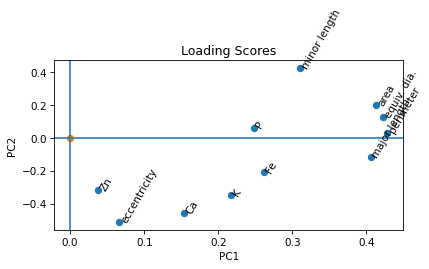

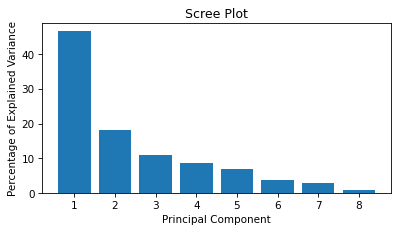

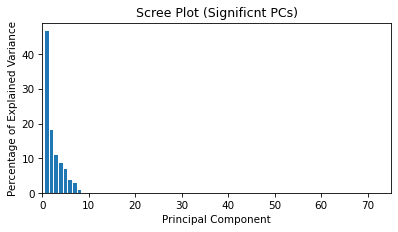

/home/otheruser/anaconda3/envs/tf2GPU/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/otheruser/anaconda3/envs/tf2GPU/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


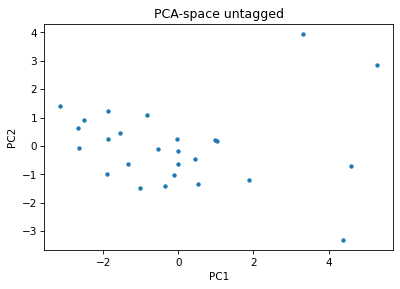

In [14]:
%matplotlib inline

feature_names = ['area','eccentricity','equiv. dia.','major length','minor length','perimeter',
        'K','P','Ca','Zn',
         'Fe']

principalComponents = XRF_PCA(mod_X, feature_names, high_comp=6, n_components=2)

#assign PC values to dataframe
secondaryDf['PC1']=principalComponents[:,0]
secondaryDf['PC2']=principalComponents[:,1]

# perform K-means

inertia:  90.31123371520208


/home/otheruser/anaconda3/envs/tf2GPU/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


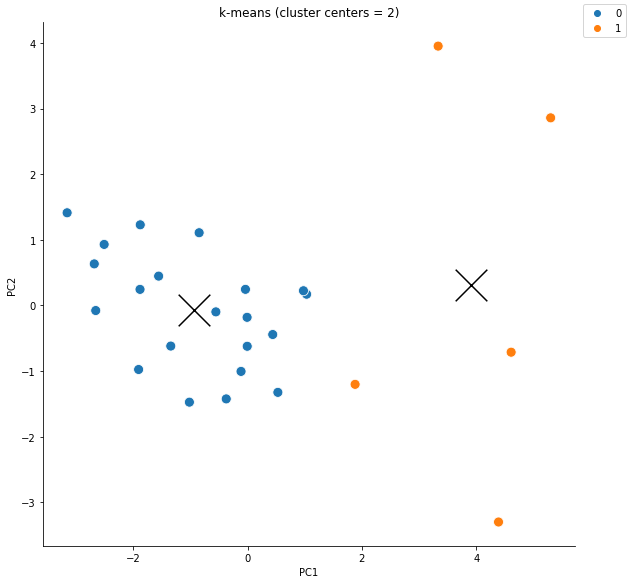

In [45]:
kmeans = KMeans(n_clusters = 2, random_state = 42).fit(secondaryDf[['PC1','PC2']].to_numpy())
inertia=kmeans.inertia_
secondaryDf['Class'] = kmeans.labels_

print('inertia: ', inertia)
pp = sns.pairplot(data=secondaryDf,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='Class', height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()
pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
pp.set(xlabel='PC1',
       ylabel='PC2',
       title='k-means (cluster centers = 2)')

plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], marker='x',s=1000, facecolors='black')

# apply a simple condition to filter the data

In [23]:
# condition check

labels = [0] * mod_X.shape[0]

True_list = secondaryDf.loc[
    (secondaryDf['major_axis_length']>=1) & 
    (secondaryDf['major_axis_length']<= 3) &
    (secondaryDf['minor_axis_length']>=0.5) & 
    (secondaryDf['minor_axis_length']<= 1.5) &
    (secondaryDf['K']<=secondaryDf['K'].median())
   ].index.tolist()    
    
print('Length true list: ', len(True_list) )

for idx in True_list:
    labels[idx]=1 
    
y=labels
    
for idx in range(len(labels)):
    if labels[idx] ==0:
        labels[idx] = 'false'
    if labels[idx] ==1:
        labels[idx] = 'true'
        
secondaryDf['text_labels'] = labels

pp = sns.pairplot(data=secondaryDf,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='text_labels',  height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()

pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
print(leg_labels)

pp.set(xlabel='PC1',
       ylabel='PC2',
       title='Principal component analysis (conditional filtering)')



Length true list:  8


/home/otheruser/anaconda3/envs/tf2GPU/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [24]:
# # look for outliers if exist
# secondaryDf[secondaryDf['PC2']>8]

In [25]:
# # check if the filtering true false labels are correct

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     display(secondaryDf)

# view distribution of features for the two kmeans classes

Text(0.5, 1.0, 'k-means (class = 1)')

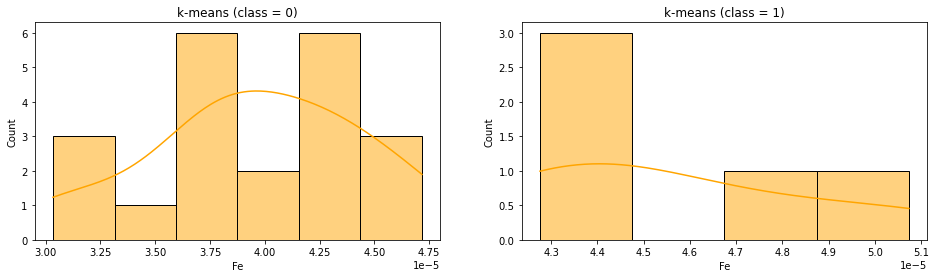

In [44]:
select_feature_channel = 'K'

secondaryDf[secondaryDf['Class']==0][select_feature_channel]
%matplotlib inline

fig, ax = plt.subplots(1, 2, figsize=(16, 4))

sns.histplot(ax=ax[0],data=secondaryDf[secondaryDf['Class']==0], x=select_feature_channel, kde=True,color='orange')
ax[0].set_title('k-means (class = 0)')

sns.histplot(ax=ax[1],data=secondaryDf[secondaryDf['Class']==1], x=select_feature_channel, kde=True,color='orange')
ax[1].set_title('k-means (class = 1)')

<IPython.core.display.Javascript object>


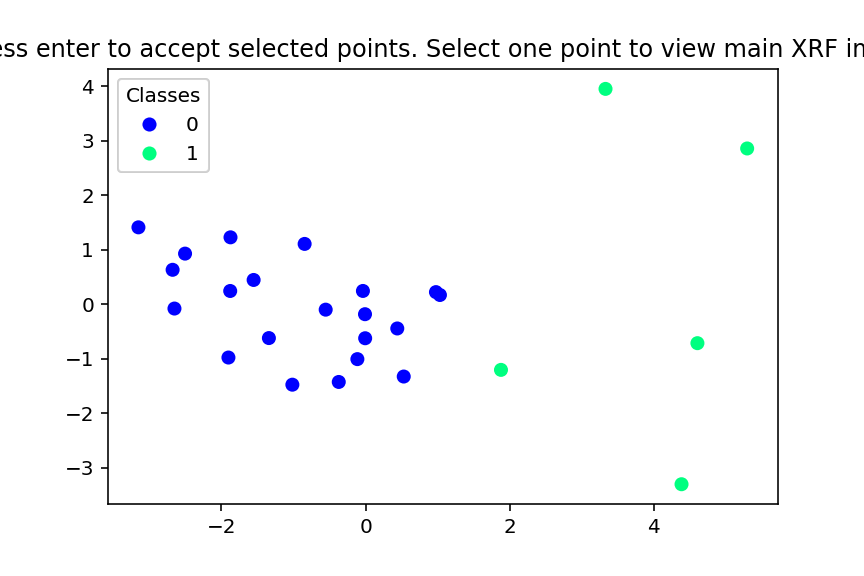

In [20]:

%matplotlib notebook

subplot_kw = dict(autoscale_on=True)
fig, ax = plt.subplots(subplot_kw=subplot_kw)

# pts = ax.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], marker='x',s=1000,c=secondaryDf.Class, facecolors='black')

pts = ax.scatter(secondaryDf['PC1'].to_numpy(),secondaryDf['PC2'].to_numpy(), c=secondaryDf.Class,
                 cmap='winter')


# produce a legend with the unique colors from the scatter
legend = ax.legend(*pts.legend_elements(),
                    loc="upper left", title="Classes")
ax.add_artist(legend)


selector = SelectFromCollection(ax, pts)



fig.canvas.mpl_connect("key_press_event", accept)
ax.set_title("Press enter to accept selected points. Select one point to view main XRF image")

plt.show()



In [21]:
#shows selected indices in secondaryDf

print('number of selected cells:', len(selector.ind))

print('modified_indices:', selector.ind)

#conversions to original indices
target_scan_cell_indices = secondaryDf['original index'][selector.ind].to_numpy()
print('original indices:', target_scan_cell_indices)
print('K-means classes \n')
secondaryDf['Class'][selector.ind]

print('cell centers (pixel value in XRF image):' , X_centers[target_scan_cell_indices])
print('\n')
print('cell centers in x (pixel value in XRF image):' , X_centers[target_scan_cell_indices][0])
print('\n')
print('cell x_origins (motor coordinates):' , X_x_origin[target_scan_cell_indices])
print('\n')
print('cell y_origins (motor coordinates):' , X_y_origin[target_scan_cell_indices])

print('\n')
print('send to motor')
print('cell x_center (motor coordinates):' , X_x_motor[target_scan_cell_indices])
print('\n')
print('cell y_center (motor coordinates):' , X_y_motor[target_scan_cell_indices])
print('\n')

print('BBox motor width (x): ', BASE_PATCH_WIDTH*X_x_res[target_scan_cell_indices])
print('BBox motor width (y): ', BASE_PATCH_WIDTH*X_y_res[target_scan_cell_indices])


print('Main XRF image file (selected):' , X_xrf_track_files[target_scan_cell_indices])

motor_coordinates = np.vstack((X_x_motor[target_scan_cell_indices],X_y_motor[target_scan_cell_indices])).T
print(motor_coordinates)


number of selected cells: 0
modified_indices: []
original indices: []
K-means classes 

cell centers (pixel value in XRF image): []




IndexError: index 0 is out of bounds for axis 0 with size 0